In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [3]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers , layers, applications

In [4]:
filenames = os.listdir("/content/drive/MyDrive/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<Axes: >

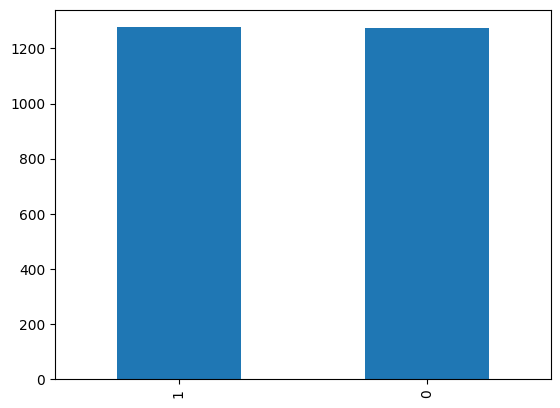

In [5]:
train_df['category'].value_counts().plot.bar()

In [9]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [10]:
test_df.head()

,filename,category
0,Autistic.15.jpg,1
1,Autistic.17.jpg,1
2,Autistic.70.jpg,1
3,Autistic.69.jpg,1
4,Autistic.26.jpg,1


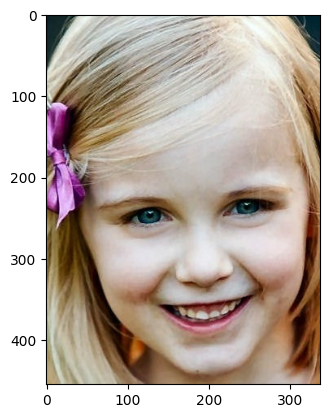

In [12]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/AutismDataset/train/"+sample)
plt.imshow(image)

In [14]:
image.size

(337, 455)

In [15]:
image_size = 224
input_shape = (image_size, image_size, 3)

#Hyperparameters
epochs = 10
batch_size = 20

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [17]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [18]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/AutismDataset/train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2295 validated image filenames belonging to 2 classes.


In [19]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/AutismDataset/train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 255 validated image filenames belonging to 2 classes.


In [ ]:
#Fit Model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

<ipython-input-20-d06c556e144e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
114/114 [==============================] - 4197s 37s/step - loss: 0.7294 - accuracy: 0.5059 - val_loss: 0.6951 - val_accuracy: 0.4875
Epoch 2/10
 17/114 [===>..........................] - ETA: 57:05 - loss: 0.7020 - accuracy: 0.4647

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "../input/autism-image-data/AutismDataset/test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

In [ ]:
threshold = 0.5
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)


In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/autism-image-data/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")